<a href="https://colab.research.google.com/github/sagarbhadra7/SMS-filteration/blob/master/SMS_spam_ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
import itertools 
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from gensim.models import TfidfModel 
from gensim.corpora import Dictionary
from gensim import corpora
from gensim import models
from nltk.tokenize import WordPunctTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Reading data from the CSV file and renameing the columns for meaning full name.

In [8]:
## Reading the dataset as a csv file
sms_df = pd.read_csv("/content/sms.csv", encoding="ISO-8859-1")
 
## Renaming columns
sms_df.columns=["Number","Labels","Message"]

Adding a new column to contain target variable for the analyis purpose and visualization.


In [9]:
sms_df["b_Labels"] = [0 if x=="ham" else 1 for x in sms_df["Labels"] ]
Y = sms_df["b_Labels"].to_numpy()
sms_df.head()

,Number,Labels,Message,b_Labels
0,1,ham,"Go until jurong point, crazy.. Available only ...",0
1,2,ham,Ok lar... Joking wif u oni...,0
2,3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,4,ham,U dun say so early hor... U c already then say...,0
4,5,ham,"Nah I don't think he goes to usf, he lives aro...",0


Find count and unique messages count of messages

In [10]:
sms_df['Message'].describe()

count                       5572
unique                      5168
top       Sorry, I'll call later
freq                          30
Name: Message, dtype: object

Plot the counts of HAM (non SPAM) vs SPAM

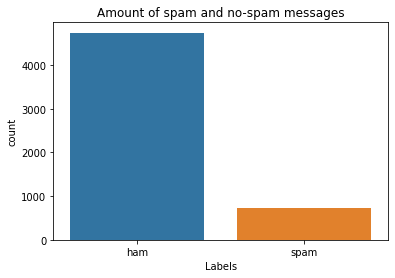

In [11]:
sns.countplot(data = sms_df, x= sms_df["Labels"]).set_title("Amount of spam and no-spam messages")
plt.show()

adding new column in data of message length 

In [12]:
sms_df['length'] = sms_df['Message'].apply(len)
sms_df.head()

,Number,Labels,Message,b_Labels,length
0,1,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,2,ham,Ok lar... Joking wif u oni...,0,29
2,3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,4,ham,U dun say so early hor... U c already then say...,0,49
4,5,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Plot histogram to visualize the length distribution in the spam and ham messages.

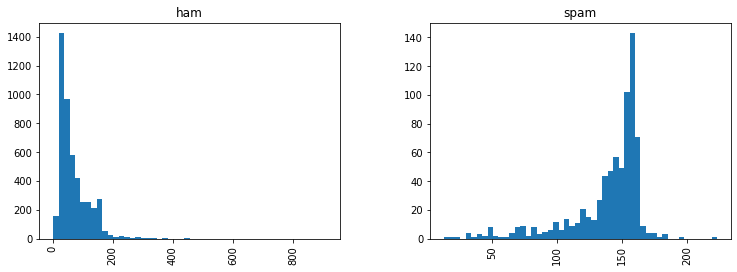

In [13]:
sms_df.hist(column='length', by='Labels', bins=50,figsize=(12,4))
plt.show()

From the above histogram, we can analyse that,
1) Ham message contains less words in message and length of ham mesages are varies between 1 to 100 more.
2) Spam message contains more words in message and length of spam mesages are varies between 140 to 160 more.

Visualizing the ratio of the spam to ham message in data

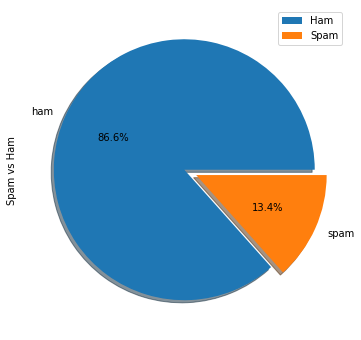

In [14]:
sms_df["Labels"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

Doing data cleaning in the message like, removing hyperlinks, punctuation , appostophes.

In [15]:
def cleaning_message_data(sentence):
    ## removing web links from message
    message = [ re.sub(r'http\S+', '', sentence.lower())]
    ## removing words like gooood and poooor to good and poor from message
    message = [''.join(''.join(message)[:2] for _, message in itertools.groupby(message[0]))]
    ## removing appostophes from message
    message = [remove_appostophes(message[0])]
    ## removing Short words from message
    message = [remove_short_word(message[0])]
    ## removing punctuations from the message 
    message = [remove_punctuations(message[0])]
    return message[0]

Function to remove the punctuations from the message using nltk.punctuation function

In [16]:
def remove_punctuations(my_str):
    punctuations = string.punctuation
    no_punct = ""
    for char in my_str:
       if char not in punctuations:
           no_punct = no_punct + char
    return no_punct

Function to remove the appostophes from the message.

In [17]:
def remove_appostophes(sentence):
  # Apostrophe Dictionary
  apostrophe_dict = {  "ain't": "am not / are not",  "aren't": "are not / am not",  "can't": "cannot",  "can't've": "cannot have",  "'cause": "because",  "could've": "could have",
  "couldn't": "could not",  "couldn't've": "could not have",  "didn't": "did not",  "doesn't": "does not",  "don't": "do not",  "hadn't": "had not",  "hadn't've": "had not have",  "hasn't": "has not",  "haven't": "have not",
  "he'd": "he had / he would",  "he'd've": "he would have",  "he'll": "he shall / he will",  "he'll've": "he shall have / he will have",
  "he's": "he has / he is",  "how'd": "how did",  "how'd'y": "how do you",  "how'll": "how will",  "how's": "how has / how is",
  "i'd": "I had / I would",  "i'd've": "I would have",  "i'll": "I shall / I will",  "i'll've": "I shall have / I will have",
  "i'm": "I am",  "i've": "I have",  "isn't": "is not",  "it'd": "it had / it would",  "it'd've": "it would have",  "it'll": "it shall / it will",
  "it'll've": "it shall have / it will have",  "it's": "it has / it is",  "let's": "let us",  "ma'am": "madam",  "mayn't": "may not",
  "might've": "might have",  "mightn't": "might not",  "mightn't've": "might not have",  "must've": "must have",  "mustn't": "must not",
  "mustn't've": "must not have",  "needn't": "need not",  "needn't've": "need not have",  "o'clock": "of the clock",  "oughtn't": "ought not",
  "oughtn't've": "ought not have",  "shan't": "shall not",  "sha'n't": "shall not",  "shan't've": "shall not have",  "she'd": "she had / she would",
  "she'd've": "she would have",  "she'll": "she shall / she will",  "she'll've": "she shall have / she will have",  "she's": "she has / she is",
  "should've": "should have",  "shouldn't": "should not",  "shouldn't've": "should not have",  "so've": "so have",  "so's": "so as / so is",
  "that'd": "that would / that had",  "that'd've": "that would have",  "that's": "that has / that is",  "there'd": "there had / there would",
  "there'd've": "there would have",  "there's": "there has / there is",  "they'd": "they had / they would",  "they'd've": "they would have",
  "they'll": "they shall / they will",  "they'll've": "they shall have / they will have",  "they're": "they are",  "they've": "they have",  "to've": "to have",
  "wasn't": "was not",  "we'd": "we had / we would",  "we'd've": "we would have",  "we'll": "we will",  "we'll've": "we will have",
  "we're": "we are",  "we've": "we have",  "weren't": "were not",  "what'll": "what shall / what will",  "what'll've": "what shall have / what will have",
  "what're": "what are",  "what's": "what has / what is",  "what've": "what have",  "when's": "when has / when is",  "when've": "when have",
  "where'd": "where did",  "where's": "where has / where is",  "where've": "where have",  "who'll": "who shall / who will",
  "who'll've": "who shall have / who will have",  "who's": "who has / who is",  "who've": "who have",  "why's": "why has / why is",
  "why've": "why have",  "will've": "will have",  "won't": "will not",  "won't've": "will not have",  "would've": "would have",
  "wouldn't": "would not",  "wouldn't've": "would not have",  "y'all": "you all",  "y'all'd": "you all would",  "y'all'd've": "you all would have",
  "y'all're": "you all are",  "y'all've": "you all have",  "you'd": "you had / you would",  "you'd've": "you would have",
  "you'll": "you shall / you will",  "you'll've": "you shall have / you will have",  "you're": "you are",  "you've": "you have"}
  words = nltk.tokenize.word_tokenize(sentence)
  final_words=[]
  for word in words:
      broken_words=word.split("'")
      for single_words in broken_words:
          final_words.append(single_words)
  reformed = [apostrophe_dict[word] if word in apostrophe_dict else word for word in final_words]
  reformed = " ".join(reformed)
  return reformed

Function to remove the short words from the message.

In [18]:
def remove_short_word(sentence):
  short_word_dict = {"121": "one to one","ve":"have","wkly":"weekly","c":"see","a/s/l": "age, sex, location","adn": "any day now","afaik": "as far as I know","afk": "away from keyboard",
  "aight": "alright","alol": "actually laughing out loud","b4": "before","b4n": "bye for now","bak": "back at the keyboard",
  "bf": "boyfriend","bff": "best friends forever","bfn": "bye for now","bg": "big grin","bta": "but then again","btw": "by the way",
  "cid": "crying in disgrace","cnp": "continued in my next post","cp": "chat post","cu": "see you","cul": "see you later",
  "cul8r": "see you later","cya": "bye","cyo": "see you online","dbau": "doing business as usual","fud": "fear, uncertainty, and doubt",
  "fwiw": "for what it's worth","fyi": "for your information","g": "grin","g2g": "got to go","ga": "go ahead","gal": "get a life",
  "gf": "girlfriend","gfn": "gone for now","gmbo": "giggling my butt off","gmta": "great minds think alike","h8": "hate",
  "hagn": "have a good night","hdop": "help delete online predators","hhis": "hanging head in shame","iac": "in any case",
  "ianal": "I am not a lawyer","ic": "I see","idk": "I don't know","imao": "in my arrogant opinion","imnsho": "in my not so humble opinion",
  "imo": "in my opinion","iow": "in other words","ipn": "I’m posting naked","irl": "in real life","jk": "just kidding","l8r": "later",
  "ld": "later, dude","ldr": "long distance relationship","llta": "lots and lots of thunderous applause","lmao": "laugh my ass off",
  "lmirl": "let's meet in real life","lol": "laugh out loud","ltr": "longterm relationship","lulab": "love you like a brother",
  "lulas": "love you like a sister","luv": "love","m/f": "male or female","m8": "mate","milf": "mother I would like to fuck",
  "oll": "online love","omg": "oh my god","otoh": "on the other hand","pir": "parent in room","ppl": "people","r": "are",
  "rofl": "roll on the floor laughing","rpg": "role playing games","ru": "are you","shid": "slaps head in disgust","somy": "sick of me yet",
  "sot": "short of time","thanx": "thanks","thx": "thanks","ttyl": "talk to you later","u": "you","ur": "you are","uw": "you’re welcome",
  "wb": "welcome back","wfm": "works for me","wibni": "wouldn't it be nice if","wtf": "what the fuck","wtg": "way to go","wtgp": "want to go private","ym": "young man","gr8": "great"}
  words = nltk.tokenize.word_tokenize(sentence)
  final_words=[]
  for word in words:
      broken_words=word.split("'")
      for single_words in broken_words:
          final_words.append(single_words)
  reformed = [short_word_dict[word] if word in short_word_dict else word for word in final_words]
  reformed = " ".join(reformed)
  return reformed

Doing Lammaztize the words in the sentances.

In [19]:
def convert_lemmatize(sentence):
  lem=WordNetLemmatizer()
  words=[lem.lemmatize(w) for w in sentence.split()]
  words=' '.join(words)
  return words

This is for loop to clean the data and stored it back again in the message column

In [20]:
for index in range(0,len(sms_df["Message"])):
  sms_df.loc[index,"Message"] = cleaning_message_data(sms_df["Message"].iloc[index])
  sms_df.loc[index,"Message"] = convert_lemmatize(sms_df["Message"].iloc[index])

In [21]:
sms_df.head(15)

,Number,Labels,Message,b_Labels,length
0,1,ham,go until jurong point crazy available only in ...,0,111
1,2,ham,ok lar joking wif you oni,0,29
2,3,spam,free entry in 2 a weekly comp to win fa cup fi...,1,155
3,4,ham,you dun say so early hor you see already then say,0,49
4,5,ham,nah i do n t think he go to usf he life around...,0,61
5,6,spam,freemsg hey there darling it s been 3 week s n...,1,147
6,7,ham,even my brother is not like to speak with me t...,0,77
7,8,ham,a per your request melle melle oru minnaminung...,0,160
8,9,spam,winner a a valued network customer you have be...,1,157
9,10,spam,had your mobile 11 month or more you are entit...,1,154


In [26]:
def my_tokeniser(s):
    s = cleaning_message_data(s)
    s=str(s)
    s = s.lower()
    stoplist  = set(stopwords.words('english')) 
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.tokenize.word_tokenize(s)
    tokens = [t for t in tokens if len(t)>2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in stoplist ]
    return tokens

In [27]:
def get_grams(label,n):
    bigrams = []
    for sentence in sms_df[sms_df["b_Labels"]==label]["Message"]:
        tokens = my_tokeniser(sentence)
        bigrams.append(tokens)
    bigrams_final=[]
    bigrams_values=0
    bigrams_Labels=0
    
    if(n==2):
        for bigram in bigrams:
            for i in range(0,len(bigram)-1):
                bigram_list_basic=bigram[i]+" "+bigram[i+1]
                bigrams_final.append(bigram_list_basic)
    else:
        for bigram in bigrams:
            for i in range(0,len(bigram)-2):
                bigram_list_basic=bigram[i]+" "+bigram[i+1]+" "+bigram[i+2]
                bigrams_final.append(bigram_list_basic)
                
    bigrams_final = pd.DataFrame(bigrams_final) 
    bigrams_final.columns=["bigrams"]
    bigrams_values=bigrams_final.groupby("bigrams")["bigrams"].count()
    bigrams_Labels=bigrams_final.groupby("bigrams").groups.keys()
    bigrams_final_result = pd.DataFrame(
    {
        "bigram":[*bigrams_Labels],
        "count":bigrams_values
    }
    )
    return bigrams_final_result

In [28]:
def plot_grams(sentiment_label,gram_n,height=4, width=14):
    bigrams_final = get_grams(sentiment_label,gram_n)
    bigrams_final = bigrams_final.sort_values("count",ascending=False).iloc[:15]
    plt.barh(bigrams_final["bigram"],bigrams_final["count"], align="center", alpha=0.7)
    plt.xlabel('Count')
    plt.title('Most common bigrams')
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.show()
    plt.rcParams["figure.figsize"] = fig_size

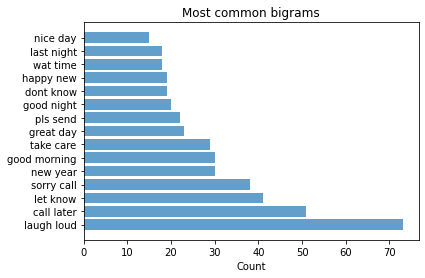

In [29]:
plot_grams(sentiment_label=0, gram_n=2)

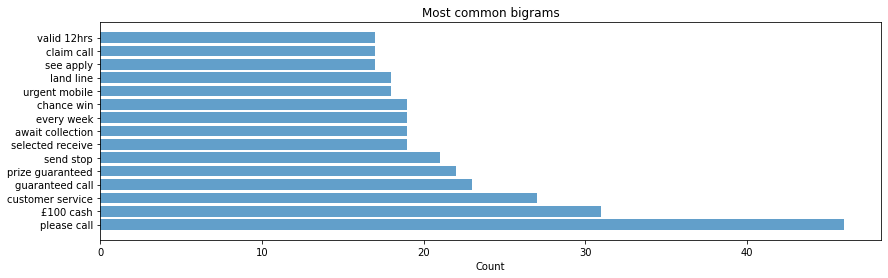

In [30]:
plot_grams(sentiment_label=1, gram_n=2)

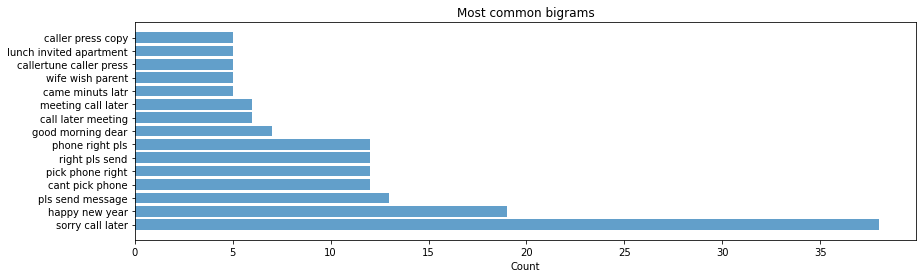

In [31]:
plot_grams(sentiment_label=0, gram_n=3)

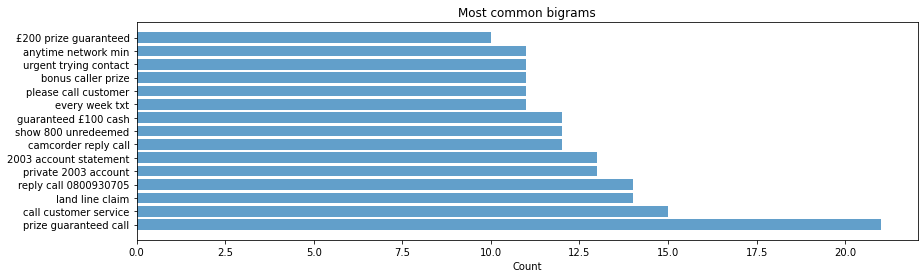

In [32]:
plot_grams(sentiment_label=1, gram_n=3)

In [33]:
def get_tfidf_matrix(documents): 
    documents=[my_tokeniser(document) for document in documents]
    dictionary = corpora.Dictionary(documents)
    n_items = len(dictionary)
    corpus = [dictionary.doc2bow(text) for text in documents]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf 

In [34]:
def get_tfidf_score_dataframe(sentiment_label):
    frames = get_tfidf_matrix(sms_df[sms_df["b_Labels"]==sentiment_label]["Message"])
    all_score=[]
    all_words=[]
    sentence_count=0
    for frame in frames:
        words=my_tokeniser(sms_df[sms_df["b_Labels"]==sentiment_label]["Message"].iloc[sentence_count])
        sentence_count=sentence_count+1
        for i in range(0,len(frame)):
            all_score.append(frame[i])
            all_words.append(words[i])
    tf_idf_frame=pd.DataFrame({
        'Words': all_words,
        'Score': all_score
    })
    count=0
    for key, val in tf_idf_frame["Score"]:
        tf_idf_frame["Score"][count] = val
        count=count+1
    return tf_idf_frame

In [38]:
def plot_tf_idf_wordcloud(sentiment_label):
    tf_idf_frame = get_tfidf_score_dataframe(sentiment_label)
    sorted_tf_idf_frame=tf_idf_frame.sort_values("Score", ascending=False)
    important_negative_words=sorted_tf_idf_frame[sorted_tf_idf_frame["Score"]==1]["Words"].unique()
    message_words=''
    for words in important_negative_words: 
        message_words = message_words + words + ' '
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = set(stopwords.words('english')),
                    min_font_size = 10).generate(message_words)                    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

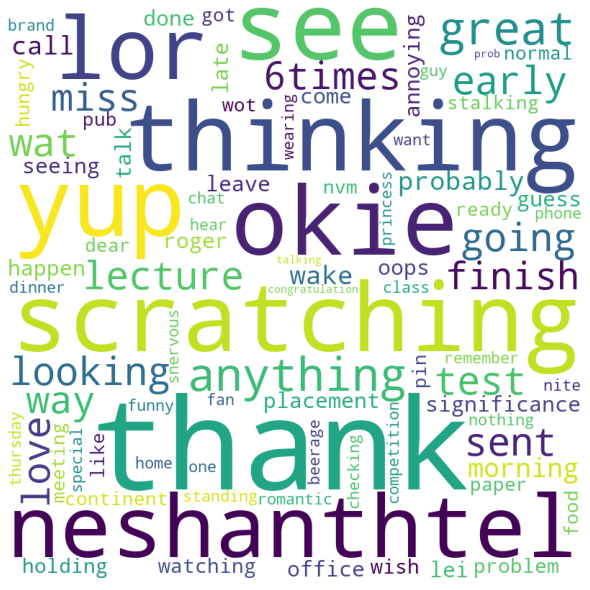

In [39]:
plot_tf_idf_wordcloud(sentiment_label=0)

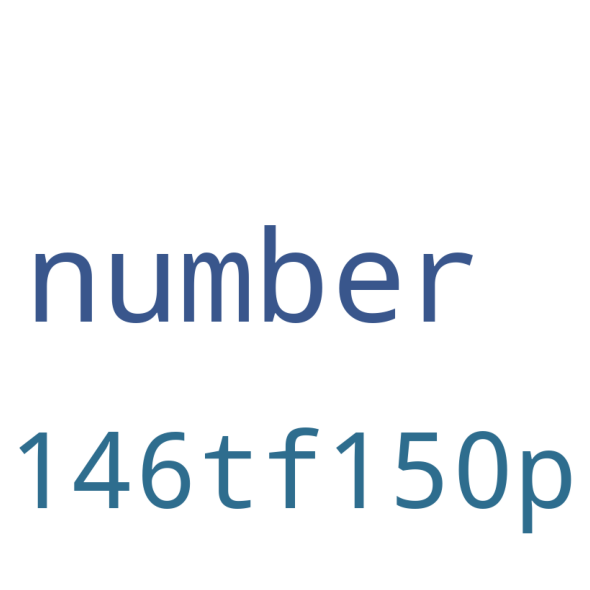

In [40]:
plot_tf_idf_wordcloud(sentiment_label=1)

partitianing data for training and prediction data set

In [ ]:
train_data = sms_df.loc[~sms_df["Labels"].isnull()]
test_data = sms_df.loc[sms_df["Labels"].isnull()]

Doing collection of raw message to a matrix of TF-IDF features and training and testing spliting of data set for model validation.

In [ ]:
vectoriser = TfidfVectorizer(decode_error="ignore")
X = vectoriser.fit_transform(list(train_data["Message"]))
y = train_data["b_Labels"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

Function has created to run all the model with same function with all the accuracy parameters to check the model accuracy

In [ ]:
def get_score(model,X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  scores = cross_val_score(model, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=10)
  y_pred = model.predict(X_test)
  print('Cross-validation mean accuracy is ',np.mean(scores) * 100)
  print('Standard deviation of accuracy is ',np.std(scores) * 100,".")
  print('Accuracy score of Model is        ',accuracy_score(y_test,y_pred))
  print('Precision score of model is       ',precision_score(y_test,y_pred))
  print('Recall score of model is          ',recall_score(y_test,y_pred))
  print('F1 score of model is              ',f1_score(y_test,y_pred))
  print('ROC AUC score is                  ',roc_auc_score(y_test,y_pred))
  matrix=pd.DataFrame(confusion_matrix(y_test,y_pred),index=[['actual', 'actual'], ['spam', 'ham']],columns=[['predicted', 'predicted'], ['spam', 'ham']])
  print(matrix)

This dictionary has created with all the models and hyper tuning paramets for GridSearchCV function

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,2,3,4,5],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1000,1500,2000,2100,2200],
            'n_jobs':[-1]
        }
    },
    'KNeighborsClassifier': {
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors':[2,3,4,5,6]
        }
    },
    'Bagging':{
        'model':BaggingClassifier(DecisionTreeClassifier()),
        'params': {
            'n_estimators':[1000,1500,2000,2100],
            'max_samples':[200,400,600,800,1000,1200],
            'bootstrap':[True,False],
            'n_jobs':[-1]            
        }
    },
    'Adaboost':{
        'model': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)),
        'params': {
            'n_estimators':[1000,1500,2000,2500],
            'algorithm':["SAMME.R"],
            'learning_rate':[0.1,0.2,0.3,0.01],
            
        }
    }, 
    'SVC_poly': {
        'model':SVC(),
        'params': {
            'kernel':["poly"],
            'degree':[4,5,6],
             'coef0':[5,10,15],
              'C':[1,2,3]            
        }
    }

}

This for loop has created to identify best hyper parameters for all the model to check the accuracy of individual model with best accuracy with best para meters.

In [ ]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
pd.options.display.max_colwidth = 10000

This is the dataset contains all the models name,best score with Best parameters with them for prediction.

In [ ]:
df

,model,best_score,best_params
0,svm,0.980080,"{'C': 5, 'kernel': 'linear'}"
1,random_forest,0.971673,"{'n_estimators': 2200, 'n_jobs': -1}"
2,KNeighborsClassifier,0.966922,{'n_neighbors': 3}
3,Bagging,0.966007,"{'bootstrap': False, 'max_samples': 1200, 'n_estimators': 2100, 'n_jobs': -1}"
4,Adaboost,0.983734,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 2000}"
5,SVC_poly,0.979349,"{'C': 1, 'coef0': 15, 'degree': 4, 'kernel': 'poly'}"


# Logistic Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression()
get_score(lr_model,X_train, X_test, y_train, y_test)

Cross-validation mean accuracy is  95.7729642748921
Standard deviation of accuracy is  0.6665526465789112 .
Accuracy score of Model is         0.9561643835616438
Precision score of model is        0.9833333333333333
Recall score of model is           0.7195121951219512
F1 score of model is               0.8309859154929577
ROC AUC score is                   0.8586819837049068
            predicted     
                 spam  ham
actual spam       929    2
       ham         46  118


# SVM Classifier

In [ ]:
svm_model = svm.SVC(C=7,kernel='linear',probability=True)
get_score(svm_model,X_train, X_test, y_train, y_test)

Cross-validation mean accuracy is  98.12628653229262
Standard deviation of accuracy is  0.46725569349968044 .
Accuracy score of Model is         0.9835616438356164
Precision score of model is        0.9802631578947368
Recall score of model is           0.9085365853658537
F1 score of model is               0.9430379746835442
ROC AUC score is                   0.9526571218988238
            predicted     
                 spam  ham
actual spam       928    3
       ham         15  149


# KNN Classifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
get_score(knn_model,X_train, X_test, y_train, y_test)

Cross-validation mean accuracy is  96.48198071115847
Standard deviation of accuracy is  0.6209988874713148 .
Accuracy score of Model is         0.960730593607306
Precision score of model is        1.0
Recall score of model is           0.7295597484276729
F1 score of model is               0.8436363636363636
ROC AUC score is                   0.8647798742138364
            predicted     
                 spam  ham
actual spam       936    0
       ham         43  116


# Bagging Classifier

In [ ]:
bag_model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=2500 ,max_samples=1400, bootstrap=False, n_jobs=-1)
get_score(bag_model,X_train, X_test, y_train, y_test)

Cross-validation mean accuracy is  96.80156316938863
Standard deviation of accuracy is  0.4077838591949396 .
Accuracy score of Model is         0.9744292237442922
Precision score of model is        0.9851851851851852
Recall score of model is           0.8364779874213837
F1 score of model is               0.9047619047619048
ROC AUC score is                   0.9171706176423158
            predicted     
                 spam  ham
actual spam       934    2
       ham         26  133


# Random Forest Classifier

In [ ]:
rnd_model= RandomForestClassifier(n_estimators=2200,n_jobs=-1)
get_score(rnd_model,X_train, X_test, y_train, y_test)

Cross-validation mean accuracy is  97.23582332842231
Standard deviation of accuracy is  0.5338361808479998 .
Accuracy score of Model is         0.9735159817351599
Precision score of model is        1.0
Recall score of model is           0.8176100628930818
F1 score of model is               0.8996539792387543
ROC AUC score is                   0.9088050314465409
            predicted     
                 spam  ham
actual spam       936    0
       ham         29  130


# Adaboost Classifier

In [ ]:
ada_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=2200,algorithm="SAMME.R", learning_rate=0.2)
get_score(ada_model,X_train, X_test, y_train, y_test)

Cross-validation mean accuracy is  98.14979676708148
Standard deviation of accuracy is  0.514336193613885 .
Accuracy score of Model is         0.9835616438356164
Precision score of model is        0.9862068965517241
Recall score of model is           0.89937106918239
F1 score of model is               0.9407894736842105
ROC AUC score is                   0.9486171585228189
            predicted     
                 spam  ham
actual spam       934    2
       ham         16  143


# SVC Poly

In [ ]:
ply_svc_model=SVC(kernel="poly", degree=4, coef0=15, C=1)
get_score(ply_svc_model,X_train, X_test, y_train, y_test)

Cross-validation mean accuracy is  98.01275822074543
Standard deviation of accuracy is  0.558717988926814 .
Accuracy score of Model is         0.9808219178082191
Precision score of model is        0.9726027397260274
Recall score of model is           0.8930817610062893
F1 score of model is               0.9311475409836065
ROC AUC score is                   0.9444041283663925
            predicted     
                 spam  ham
actual spam       932    4
       ham         17  142


Creating the final data for model fitting and prediction of SMS message data set

In [ ]:
data=pd.concat([train_data,test_data])
vectorizer = TfidfVectorizer("english",decode_error="ignore")
X= vectorizer.fit_transform(list(data['Message']))
y=data['Labels']
ratio=test_data.shape[0]/sms_df.shape[0]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=ratio, shuffle=False)

From the above analysis we can see that, Adaboost Classifier is best to predict spam and ham from data with slightly better accuracy compare to SVM.

In [ ]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=2200,algorithm="SAMME.R", learning_rate=0.2)
ada_clf.fit(X_train,y_train)
y_pred_label=ada_clf.predict(X_test)

Converting data frames into CSV file

In [ ]:
pred_data=pd.concat((pd.Series(test_data['Number'].values),pd.Series(y_pred_label)),axis=1)
pred_data.columns=['No','Result']
pred_data.to_csv('NLP.csv',index=False)